In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
# import aplpy
import matplotlib.pyplot as plt
# import pyregion
from tqdm import tqdm
from astropy.table import QTable
import warnings
import numpy as np
import imageio.v3 as iio
from reproject import reproject_interp
import astropy.units as u
from astropy.visualization import wcsaxes

from astropy.wcs import WCS
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from astropy.coordinates import SkyCoord
import colorcet

# Matplotlib style
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.weight"] = "bold"
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [2]:
def NormalizeData(data):
    data_norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
    data_norm[np.isnan(data)] = 0
    return data_norm

In [3]:
inputfile_jpeg = 'cutout-CDS_P_VistaOrion_color.jpg'
inputfile_fits = 'cutout-CDS_P_VistaOrion_color.fits'

In [4]:
image = iio.imread(inputfile_jpeg)[::-1] # flip image?
hdu = fits.open(inputfile_fits)[0]
hdu.data = hdu.data[0]
del hdu.header['*3*']
del hdu.header['WCSAXES']
wcs = WCS(hdu.header)

In [5]:
hdu_apex = fits.open('Orion_CONCERTO_ESO_2all_phot_cut.fits')[0]
wcs_apex = WCS(hdu_apex.header)

hdu_apex_err = fits.open('batch_30931/Orion_CONCERTO_ESO_2all_phot_err.fits')[0]
wcs_apex_err = WCS(hdu_apex_err.header)

data_apex_err, footprint_err = reproject_interp(hdu_apex_err, hdu_apex.header)
data_apex = hdu_apex.data /data_apex_err
hdu_apex = fits.PrimaryHDU(data_apex, header=hdu_apex.header)

data_apex, footprint = reproject_interp(hdu_apex, hdu.header)
hdu_apex = fits.PrimaryHDU(data_apex, header=hdu.header)

hdu_apex_full = fits.open('batch_30931/Orion_CONCERTO_ESO_2all_phot.fits')[0]
wcs_apex_full = WCS(hdu_apex_full.header)
data_apex_full, footprint_full = reproject_interp(hdu_apex_full, hdu.header)
hdu_apex_full = fits.PrimaryHDU(data_apex_full, header=hdu.header)
mask = ~np.isnan(hdu_apex_full.data)

Set OBSGEO-B to   -23.005700 from OBSGEO-[XYZ].
Set OBSGEO-H to     5101.996 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-END to '2022-08-24T15:10:52.320' from MJD-END'. [astropy.wcs.wcs]


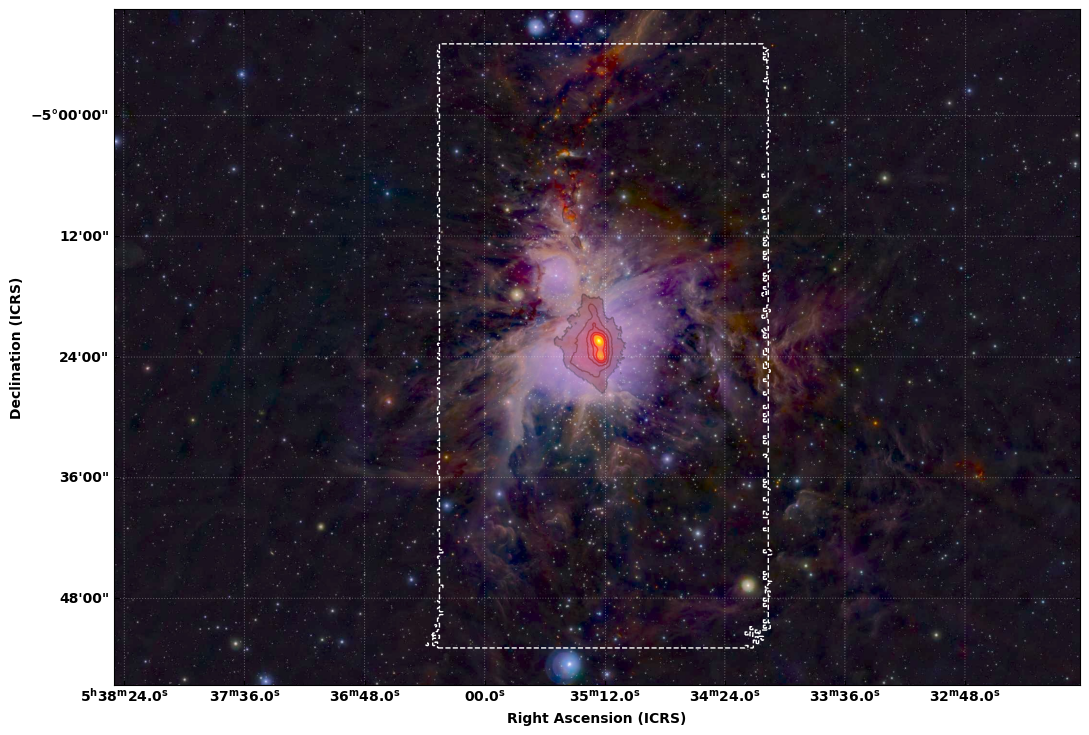

In [6]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(image, origin='lower')

alpha = NormalizeData(hdu_apex.data)
alpha = NormalizeData(np.sqrt(alpha))
alpha = NormalizeData(np.arcsinh(alpha))
alpha[alpha<0.2] = 0

cmap = colorcet.cm.fire(np.linspace(0, 1, 128))
# cmap = mpl.cm.inferno(np.linspace(0, 1, 128))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmap)

ax.imshow(alpha, origin='lower', alpha=alpha, cmap=cmap, vmin=0.1, vmax=1)
ax.contour(mask, levels=[0], colors='white', linewidths=1, alpha=1, linestyles='--')
levels = np.array([0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1])
ax.contour(alpha, levels=levels, cmap=cmap, linewidths=1, alpha=levels)

ax.coords['ra'].set_axislabel('Right Ascension (ICRS)')
ax.coords['dec'].set_axislabel('Declination (ICRS)')
ax.coords['ra'].set_major_formatter('hh:mm:ss.s')
ax.coords['dec'].set_major_formatter('dd:mm:ss')
ax.coords['ra'].set_ticks(spacing=0.2*u.degree)
ax.coords['dec'].set_ticks(spacing=0.2*u.degree)

ylim = ax.get_ylim()
height = ylim[1] - ylim[0]
ax.set_ylim(ylim[0] + 0.15*height, ylim[1] - 0.15*height)
ax.grid(color='white', ls='dotted', lw=0.75, alpha=0.3)
fig.tight_layout()